In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from data.utils import check_df, plot_importance

from tensorflow.keras.models import load_model
import joblib

from sklearn.ensemble import RandomForestClassifier


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [3]:
# === 1. VERİYİ YÜKLE ===
df = pd.read_csv("../prediction_model/data/data.csv", encoding="ISO-8859-1", sep=";")

# === 2. Hedef Değişkeni Grupla ===
def map_ktas(value):
    if value in [1, 2]:
        return 0  # kırmızı
    elif value == 3:
        return 1  # sarı
    elif value in [4, 5]:
        return 2  # yeşil
    return np.nan

df['target'] = df['KTAS_expert'].apply(map_ktas)

# === 3. Veri Temizliği ===
df = df.replace(",", ".", regex=True)  # sayısal virgülleri noktaya çevir
df = df.drop(columns=['Chief_complain', 'Diagnosis in ED', 'KTAS_expert'])
df = df.apply(pd.to_numeric, errors='coerce')  # tüm veriyi sayısala çevir
df = df.fillna(df.mean(numeric_only=True))     # eksikleri ortalama ile doldur

In [4]:
check_df(df)

##################### Shape #####################
(1267, 22)
##################### Types #####################
Group                         int64
Sex                           int64
Age                           int64
Patients number per hour      int64
Arrival mode                  int64
Injury                        int64
Mental                        int64
Pain                          int64
NRS_pain                    float64
SBP                         float64
DBP                         float64
HR                          float64
RR                          float64
BT                          float64
Saturation                  float64
KTAS_RN                       int64
Disposition                   int64
Error_group                   int64
Length of stay_min            int64
KTAS duration_min           float64
mistriage                     int64
target                        int64
dtype: object
##################### Head #####################
   Group  Sex  Age  Patients numbe

In [18]:
# Standardizing column names
df.columns = df.columns.str.lower().str.replace(' ', '_').str.strip()

In [15]:
X_feature_imp = df.drop(columns=['target'])
y_feature_imp = df['target']

In [16]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_feature_imp, y_feature_imp)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


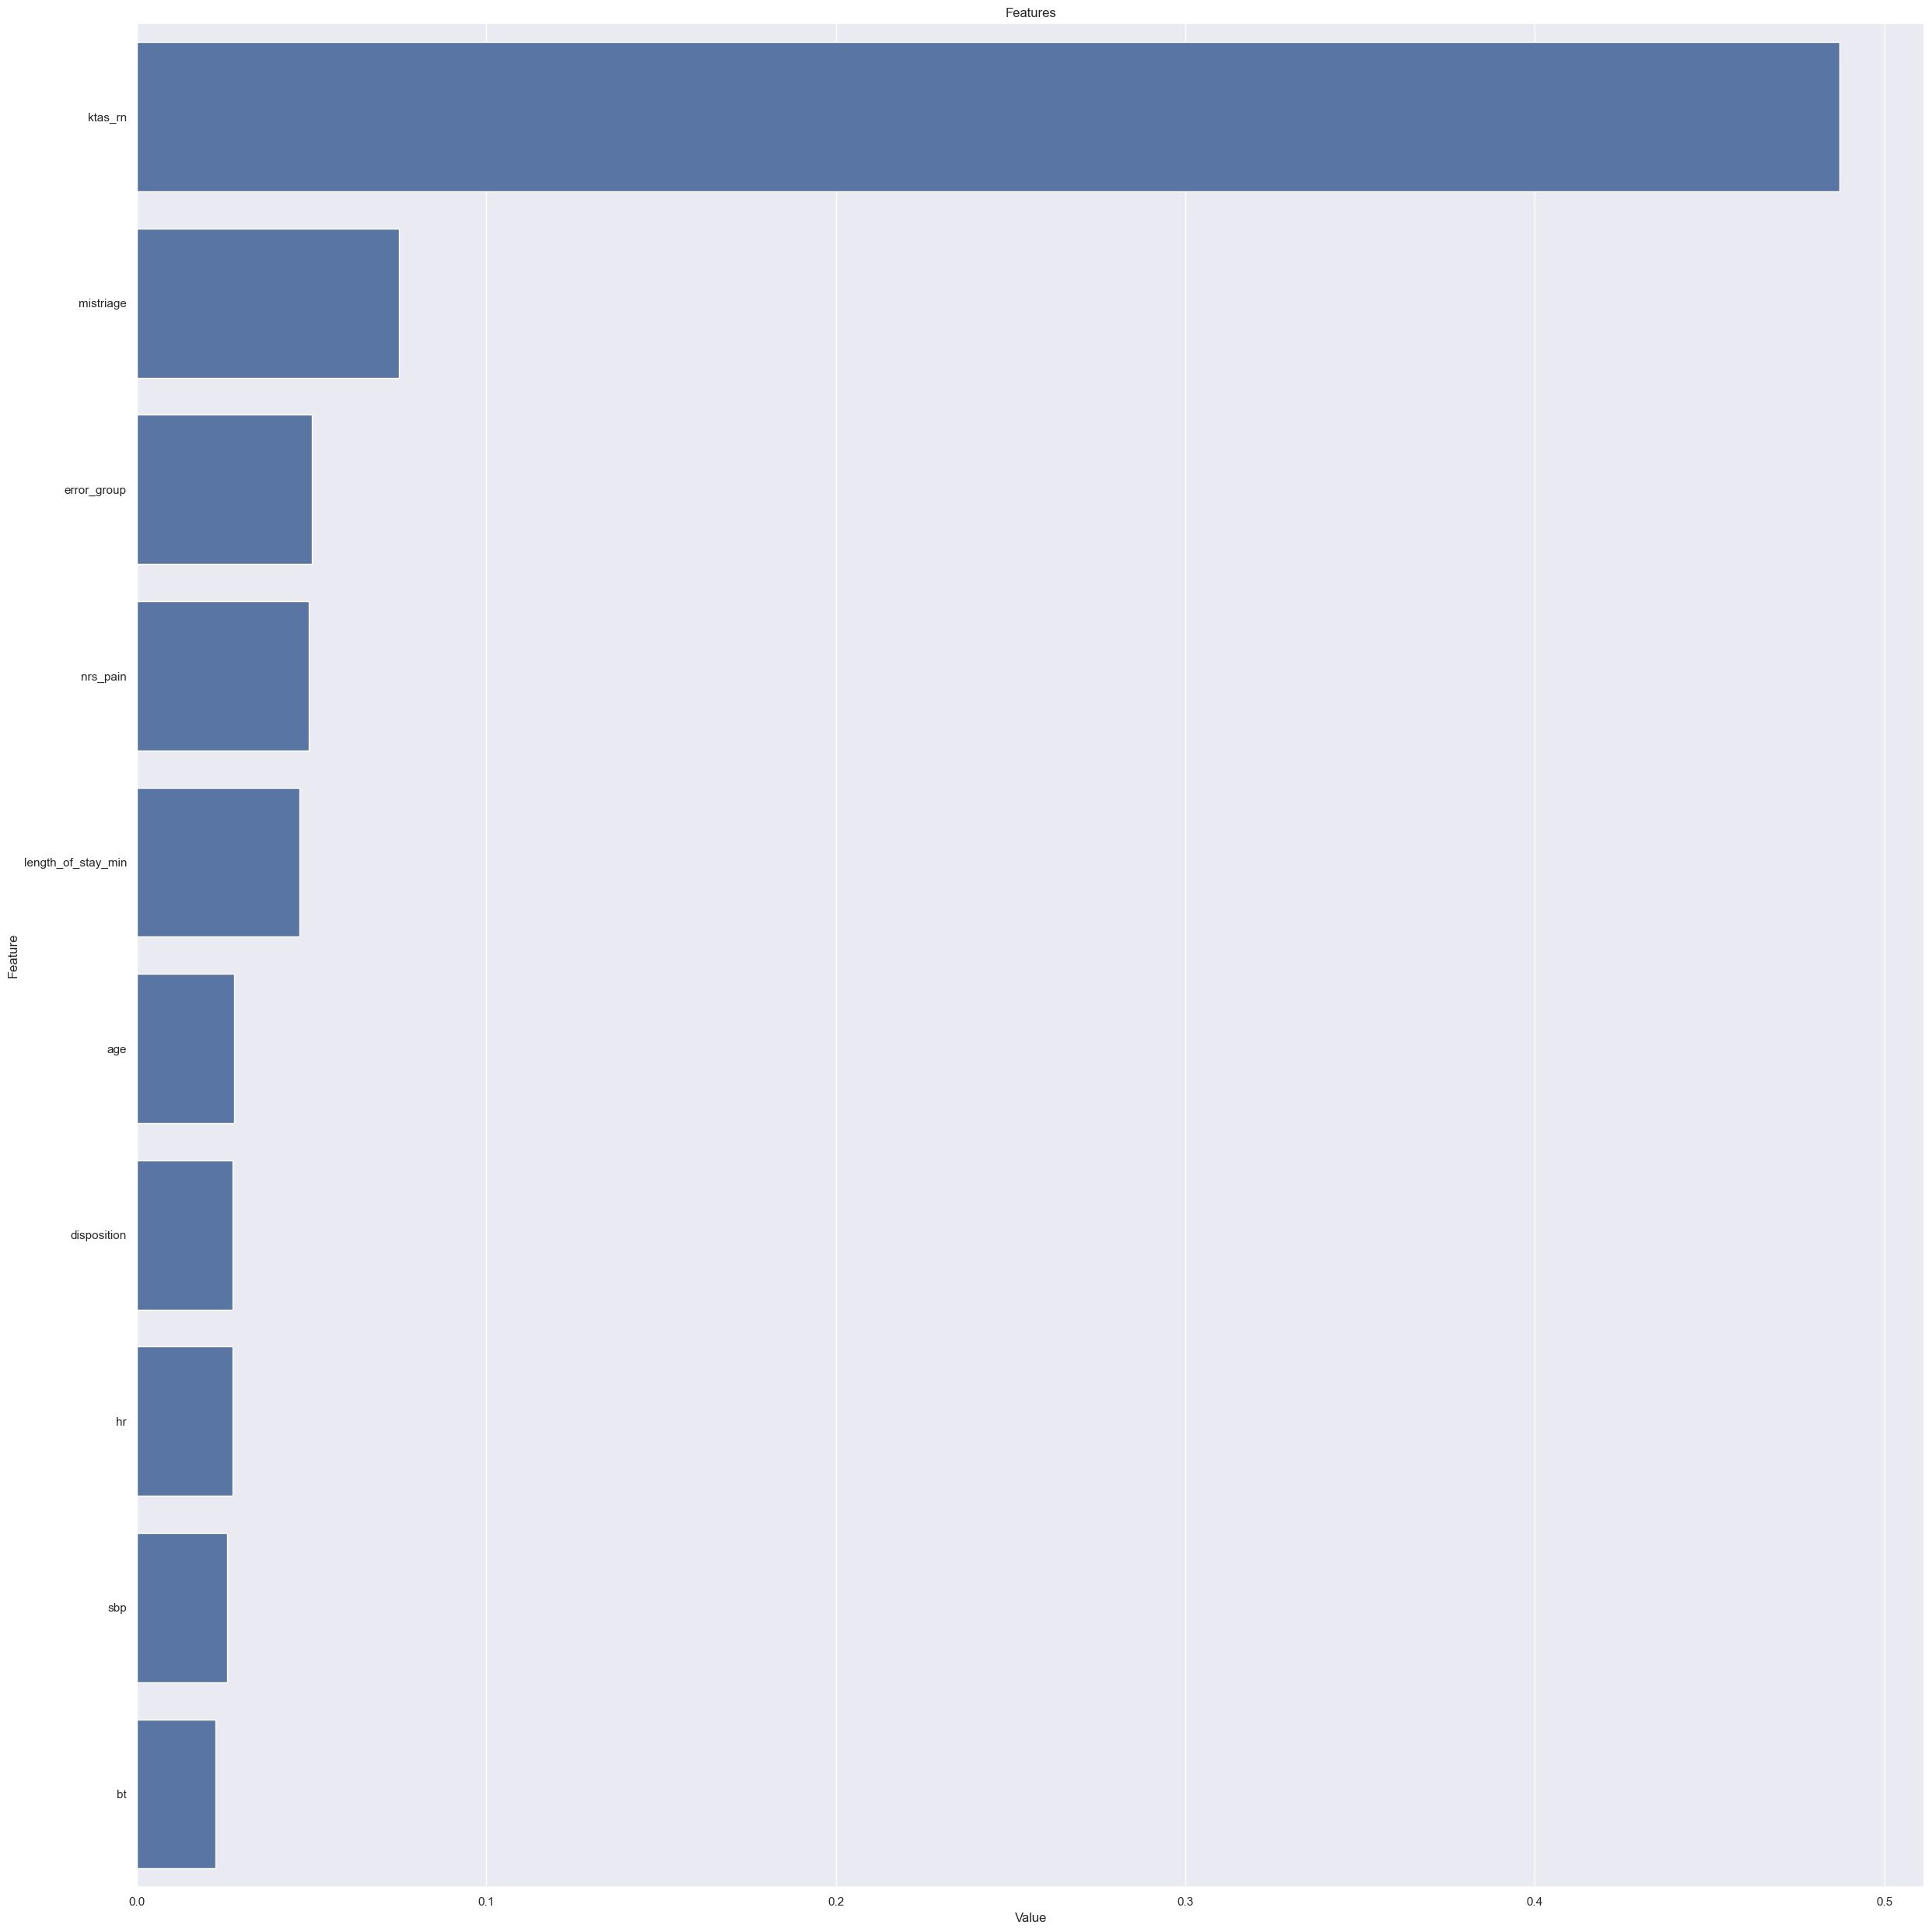

In [23]:
importances = plot_importance(rf_model, X_feature_imp, 10)

In [ ]:
importances.sort_values(by='Value', ascending=False)[importances['Value'] >= 0.02]

C:\Users\borab\AppData\Local\Temp\ipykernel_3156\1873809413.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  importances.sort_values(by='Value', ascending=False)[importances['Value'] >= 0.02]


,Value,Feature
15,0.487,ktas_rn
20,0.075,mistriage
17,0.050,error_group
8,0.049,nrs_pain
18,0.046,length_of_stay_min
2,0.028,age
16,0.027,disposition
11,0.027,hr
9,0.026,sbp
13,0.022,bt


In [29]:
selected_features = importances.sort_values(by='Value', ascending=False)[importances['Value'] >= 0.02]['Feature'].unique().tolist()

C:\Users\borab\AppData\Local\Temp\ipykernel_3156\3324471956.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  selected_features = importances.sort_values(by='Value', ascending=False)[importances['Value'] >= 0.02]['Feature'].unique().tolist()


In [32]:
print("Selected Features:", selected_features)

Selected Features: ['ktas_rn', 'mistriage', 'error_group', 'nrs_pain', 'length_of_stay_min', 'age', 'disposition', 'hr', 'sbp', 'bt', 'ktas_duration_min', 'mental', 'injury']


In [30]:
check_df(df[selected_features])

##################### Shape #####################
(1267, 13)
##################### Types #####################
ktas_rn                 int64
mistriage               int64
error_group             int64
nrs_pain              float64
length_of_stay_min      int64
age                     int64
disposition             int64
hr                    float64
sbp                   float64
bt                    float64
ktas_duration_min     float64
mental                  int64
injury                  int64
dtype: object
##################### Head #####################
   ktas_rn  mistriage  error_group  nrs_pain  length_of_stay_min  age  disposition      hr     sbp     bt  ktas_duration_min  mental  injury
0        2          1            2     2.000                  86   71            1  84.000 160.000 36.600              5.000       1       2
1        4          1            4     2.000                  64   56            1  60.000 137.000 36.500              3.950       1       2
2        4   

In [31]:
# === 4. Özellik ve Etiket Ayır ===
X = df[selected_features]
y = df['target']

# === 5. Eğitim/Test Ayrımı ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# === 6. Normalizasyon ===
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# === 7. One-hot encoding (Keras için) ===
y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

# === 8. MLP Modeli ===
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# === 9. Eğit ===
model.fit(X_train, y_train_cat, epochs=30, batch_size=32, validation_split=0.1)

# === 10. Değerlendirme ===
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

print(classification_report(y_test, y_pred, target_names=["Kırmızı", "Sarı", "Yeşil"]))
# === 11. Modeli ve scaler'ı kaydet ===

# Modeli kaydet (HDF5 formatı)
model.save("triage_model.h5")

# Scaler'ı kaydet (pickle formatı)
joblib.dump(scaler, "scaler.pkl")

print("Model ve scaler başarıyla kaydedildi.")

Epoch 1/30


c:\Dev\Repos\group155\.venv\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4435 - loss: 1.1206 - val_accuracy: 0.6961 - val_loss: 0.9327
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6498 - loss: 0.9204 - val_accuracy: 0.7353 - val_loss: 0.7892
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7036 - loss: 0.8036 - val_accuracy: 0.7745 - val_loss: 0.6626
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7311 - loss: 0.6963 - val_accuracy: 0.8039 - val_loss: 0.5717
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7849 - loss: 0.5942 - val_accuracy: 0.8431 - val_loss: 0.5069
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8024 - loss: 0.5437 - val_accuracy: 0.8431 - val_loss: 0.4611
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8233 - loss: 0.4872 - val_accuracy: 0.8725 - val_loss: 0.4241
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8683 - loss: 0.4240 - val_accuracy: 0.8824 - val_loss: 0.3946
Epo

              precision    recall  f1-score   support

     Kırmızı       0.92      1.00      0.96        49
        Sarı       0.99      0.97      0.98        98
       Yeşil       0.99      0.97      0.98       107

    accuracy                           0.98       254
   macro avg       0.97      0.98      0.97       254
weighted avg       0.98      0.98      0.98       254

Model ve scaler başarıyla kaydedildi.


In [ ]:
import gradio as gr
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model

# === MODEL YÜKLE ===
model = load_model("/content/triage_model.h5")
scaler = joblib.load("/content/scaler.pkl")

renk_map = {0: "🔴 Kırmızı (Acil)", 1: "🟡 Sarı (Orta)", 2: "🟢 Yeşil (Düşük)"}

# === SEÇENEKLERİN SAYISAL KARŞILIKLARI ===
cinsiyet_map = {"Erkek": 1, "Kadın": 2}
gelis_map = {
    "Yürüyerek geldi": 1,
    "Ambulans ile geldi": 2,
    "Başka sağlık kurumundan sevk": 3
}
travma_map = {"Hayır (Travmasız)": 1, "Evet (Travmalı)": 2}
cikis_map = {
    "Acilde kaldı / Ayaktan taburcu": 1,
    "Yatış yaptı veya başka yere sevk edildi": 2
}

# === TAHMİN FONKSİYONU ===
def tahmin_et(
    grup, cinsiyet, yas, saatlik_hasta, gelis, travma, mental, agri_var,
    nrs, sbp, dbp, hr, rr, bt, spo2, ktas_rn, cikis, hata, kalis_dk, sure_dk, yanlis_mi
):
    veri = {
        "Group": 1 if grup == "Yetişkin" else 2,
        "Sex": cinsiyet_map[cinsiyet],
        "Age": yas,
        "Patients number per hour": saatlik_hasta,
        "Arrival mode": gelis_map[gelis],
        "Injury": travma_map[travma],
        "Mental": mental,
        "Pain": agri_var,
        "NRS_pain": nrs,
        "SBP": sbp,
        "DBP": dbp,
        "HR": hr,
        "RR": rr,
        "BT": bt,
        "Saturation": spo2,
        "KTAS_RN": ktas_rn,
        "Disposition": cikis_map[cikis],
        "Error_group": hata,
        "Length of stay_min": kalis_dk,
        "KTAS duration_min": sure_dk,
        "mistriage": yanlis_mi
    }

    df = pd.DataFrame([veri])
    scaled = scaler.transform(df)
    pred = model.predict(scaled)
    sinif = np.argmax(pred)
    return renk_map[sinif]

# === ARAYÜZ ===
app = gr.Interface(
    fn=tahmin_et,
    inputs=[
        gr.Dropdown(["Yetişkin", "Çocuk"], label="Hasta grubu"),
        gr.Dropdown(["Erkek", "Kadın"], label="Cinsiyet"),
        gr.Number(label="Yaş (örnek: 65)"),
        gr.Number(label="Saatlik hasta yoğunluğu (örnek: 5)"),
        gr.Dropdown(["Yürüyerek geldi", "Ambulans ile geldi", "Başka sağlık kurumundan sevk"], label="Hastanın geliş şekli"),
        gr.Dropdown(["Hayır (Travmasız)", "Evet (Travmalı)"], label="Hastada travma var mı?"),
        gr.Number(label="Zihinsel durum (1: Normal, 2: Bilinç bulanıklığı)", value=1),
        gr.Number(label="Ağrısı var mı? (1: Hayır, 2: Evet)", value=1),
        gr.Number(label="Ağrı şiddeti (0–10 arası)", value=3),
        gr.Number(label="Sistolik Kan Basıncı (örnek: 120)"),
        gr.Number(label="Diastolik Kan Basıncı (örnek: 80)"),
        gr.Number(label="Nabız (örnek: 75)"),
        gr.Number(label="Solunum Sayısı (örnek: 16)"),
        gr.Number(label="Vücut Isısı (°C, örnek: 36.8)"),
        gr.Number(label="Oksijen Saturasyonu (örnek: 98)"),
        gr.Number(label="Hemşire KTAS Puanı (1–5)", value=3),
        gr.Dropdown(["Acilde kaldı / Ayaktan taburcu", "Yatış yaptı veya başka yere sevk edildi"], label="Çıkış durumu"),
        gr.Number(label="Hata grubu (örnek: 2)"),
        gr.Number(label="Hastanede kalış süresi (dakika)", value=60),
        gr.Number(label="KTAS değerlendirme süresi (dakika)", value=5.0),
        gr.Number(label="Yanlış sınıflandırma mı? (1=Evet, 0=Hayır)", value=0)
    ],
    outputs=gr.Textbox(label="🩺 Tahmin Edilen Aciliyet Seviyesi"),
    title="🏥 Acil Triage Tahmin Uygulaması",
    description="Aşağıdaki hasta bilgilerini girerek sistemin tahmin ettiği aciliyet düzeyini (Kırmızı, Sarı, Yeşil) öğrenebilirsiniz."
)

app.launch()
